# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

**Cấu hình Seed để đảm bảo tính tái lập trong mô hình LSTM**  

1️⃣ `np.random.seed(1)`  
✅ Đặt **seed** cho NumPy.  
✅ Ảnh hưởng đến tất cả các hàm tạo số ngẫu nhiên của NumPy như:  
   - `np.random.rand()`  
   - `np.random.randn()`  
   - `np.random.randint()`  
   - ...  

2️⃣ `rn.seed(3)`  
✅ Đặt **seed** cho thư viện `random` của Python.  
✅ Ảnh hưởng đến các hàm như:  
   - `random.random()`  
   - `random.randint()`  
   - `random.choice()`  
   - ...  

3️⃣ `tf.random.set_seed(2)`  
✅ Đặt **seed** cho TensorFlow.  
✅ Ảnh hưởng đến:  
   - Việc khởi tạo trọng số ngẫu nhiên của mô hình **TensorFlow/Keras**, ví dụ:  
     - `tf.keras.layers.Dense`  
     - `tf.keras.layers.LSTM`  
   - Các phép toán sử dụng số ngẫu nhiên trong TensorFlow như:  
     - `tf.random.uniform()`  
     - `tf.random.normal()`  
     - ...  

📌 **Ghi chú:**  
- Việc đặt **seed** giúp đảm bảo **tính tái lập** trong các lần chạy mô hình.  
- Điều này giúp so sánh kết quả giữa các lần thử nghiệm một cách chính xác hơn.  


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var_hpg_rnn.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of              open   high    low  close    volume
time                                            
2007-11-16   2.29   2.29   2.29   2.29    248510
2007-11-19   2.17   2.17   2.17   2.17    120480
2007-11-20   2.08   2.08   2.08   2.08     58710
2007-11-21   1.99   2.16   1.99   2.16    728080
2007-11-22   2.16   2.16   2.08   2.16    266040
...           ...    ...    ...    ...       ...
2025-03-14  27.70  27.85  27.55  27.55  18279900
2025-03-17  27.90  28.15  27.75  27.85  19719700
2025-03-18  27.90  28.05  27.60  27.60  18741700
2025-03-19  27.60  27.60  27.10  27.25  37925600
2025-03-20  27.30  27.45  27.05  27.15  25022500

[4322 rows x 5 columns]>


In [9]:
print(df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

**Phân tích tương quan giữa các biến trong dữ liệu chuỗi thời gian**  

🔹 `df.corr()`  
- Tính **ma trận tương quan** giữa tất cả các cột số trong DataFrame.  

🔹 `df.corr()['Close']`  
- Lấy **cột tương quan** giữa tất cả các biến với **giá đóng cửa** (`Close`).  
- Giúp xác định mức độ ảnh hưởng của các biến khác như:  
  - **Giá mở cửa** (`Open`)  
  - **Giá cao nhất** (`High`)  
  - **Giá thấp nhất** (`Low`)  
  - **Khối lượng giao dịch** (`Volume`)  

**Ý nghĩa của tương quan**  

- **Tương quan gần 1** → Biến có mối quan hệ **tỷ lệ thuận** mạnh với giá đóng cửa.  
- **Tương quan gần -1** → Biến có mối quan hệ **tỷ lệ nghịch** mạnh với giá đóng cửa.  
- **Tương quan gần 0** → Biến **ít hoặc không ảnh hưởng** đến giá đóng cửa.  

**Ứng dụng**  

- Chọn các biến có tương quan cao với `Close` để đưa vào mô hình dự đoán.  
- Loại bỏ các biến có tương quan thấp để tránh nhiễu dữ liệu.  


In [13]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

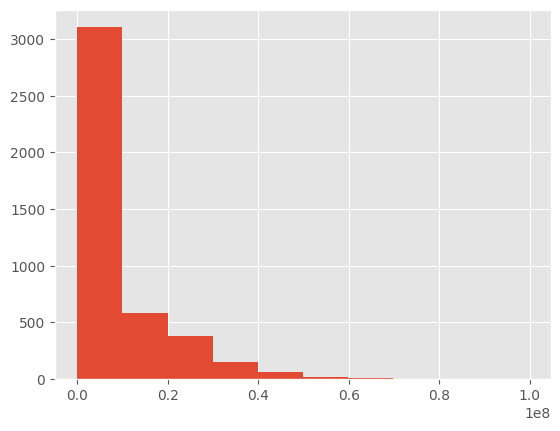

In [14]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


## Train model / Hàm **fit_model_2()**

In [15]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [16]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [17]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [18]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [19]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [20]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [21]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [22]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [23]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200,250]
}

In [24]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [25]:
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
"""
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100
"""


'\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100\n'

In [26]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [31]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [32]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [29]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(4320, 3)


,close,high,low
time,,,
2007-11-16,2.29,2.29,2.29
2007-11-19,2.17,2.17,2.17
2007-11-20,2.08,2.08,2.08
2007-11-21,2.16,2.16,1.99
2007-11-22,2.16,2.16,2.08
...,...,...,...
2025-03-14,27.55,27.85,27.55
2025-03-17,27.85,28.15,27.75
2025-03-18,27.60,28.05,27.60


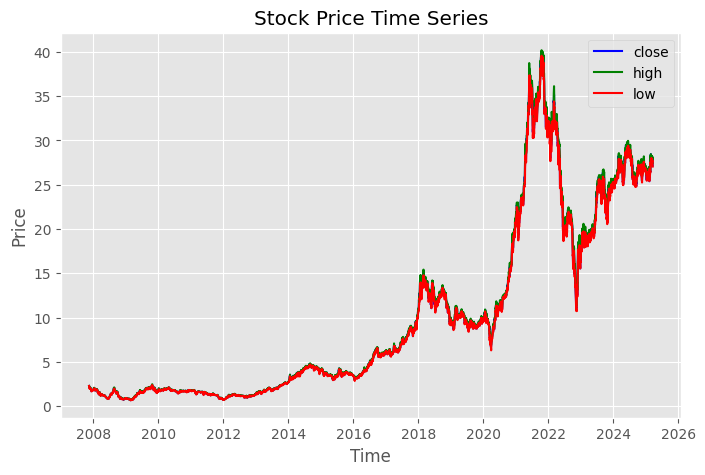

In [30]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [31]:
series.shape

(4320, 3)

In [32]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(3024, 3) (648, 3) (648, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [33]:
# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(3024, 3) (648, 3) (648, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [34]:
from keras.layers import GRU

In [35]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 3.14491, saving model to 3Var_hpg_rnn.h5



Epoch 2: val_loss improved from 3.14491 to 2.59747, saving model to 3Var_hpg_rnn.h5



Epoch 3: val_loss improved from 2.59747 to 1.99868, saving model to 3Var_hpg_rnn.h5



Epoch 4: val_loss improved from 1.99868 to 1.49094, saving model to 3Var_hpg_rnn.h5



Epoch 5: val_loss improved from 1.49094 to 1.13014, saving model to 3Var_hpg_rnn.h5



Epoch 6: val_loss improved from 1.13014 to 0.80811, saving model to 3Var_hpg_rnn.h5



Epoch 7: val_loss improved from 0.80811 to 0.52922, saving model to 3Var_hpg_rnn.h5



Epoch 8: val_loss improved from 0.52922 to 0.32047, saving model to 3Var_hpg_rnn.h5



Epoch 9: val_loss improved from 0.32047 to 0.18619, saving model to 3Var_hpg_rnn.h5



Epoch 10: val_loss improved from 0.18619 to 0.10024, saving model to 3Var_hpg_rnn.h5



Epoch 11: val_loss improved from 0.10024 to 0.06532, saving model to 3Var_hpg_rnn.h5



Epoch 12: val_loss improved from 0.06532 to 0.05078, saving model to 3Var_hpg_rnn.h5



Epoch 13: val_loss improved from 0.05078 to 0.04305, saving model to 3Var_hpg_rnn.h5



Epoch 14: val_loss improved from 0.04305 to 0.03879, saving model to 3Var_hpg_rnn.h5



Epoch 15: val_loss improved from 0.03879 to 0.03577, saving model to 3Var_hpg_rnn.h5



Epoch 16: val_loss improved from 0.03577 to 0.03333, saving model to 3Var_hpg_rnn.h5



Epoch 17: val_loss improved from 0.03333 to 0.03131, saving model to 3Var_hpg_rnn.h5



Epoch 18: val_loss improved from 0.03131 to 0.02970, saving model to 3Var_hpg_rnn.h5



Epoch 19: val_loss improved from 0.02970 to 0.02843, saving model to 3Var_hpg_rnn.h5



Epoch 20: val_loss improved from 0.02843 to 0.02741, saving model to 3Var_hpg_rnn.h5



Epoch 21: val_loss improved from 0.02741 to 0.02658, saving model to 3Var_hpg_rnn.h5



Epoch 22: val_loss improved from 0.02658 to 0.02586, saving model to 3Var_hpg_rnn.h5



Epoch 23: val_loss improved from 0.02586 to 0.02518, saving model to 3Var_hpg_rnn.h5



Epoch 24: val_loss improved from 0.02518 to 0.02456, saving model to 3Var_hpg_rnn.h5



Epoch 25: val_loss improved from 0.02456 to 0.02398, saving model to 3Var_hpg_rnn.h5



Epoch 26: val_loss improved from 0.02398 to 0.02340, saving model to 3Var_hpg_rnn.h5



Epoch 27: val_loss improved from 0.02340 to 0.02283, saving model to 3Var_hpg_rnn.h5



Epoch 28: val_loss improved from 0.02283 to 0.02228, saving model to 3Var_hpg_rnn.h5



Epoch 29: val_loss improved from 0.02228 to 0.02172, saving model to 3Var_hpg_rnn.h5



Epoch 30: val_loss improved from 0.02172 to 0.02121, saving model to 3Var_hpg_rnn.h5



Epoch 31: val_loss improved from 0.02121 to 0.02076, saving model to 3Var_hpg_rnn.h5



Epoch 32: val_loss improved from 0.02076 to 0.02037, saving model to 3Var_hpg_rnn.h5



Epoch 33: val_loss improved from 0.02037 to 0.02001, saving model to 3Var_hpg_rnn.h5



Epoch 34: val_loss improved from 0.02001 to 0.01958, saving model to 3Var_hpg_rnn.h5



Epoch 35: val_loss improved from 0.01958 to 0.01923, saving model to 3Var_hpg_rnn.h5



Epoch 36: val_loss improved from 0.01923 to 0.01898, saving model to 3Var_hpg_rnn.h5



Epoch 37: val_loss improved from 0.01898 to 0.01871, saving model to 3Var_hpg_rnn.h5



Epoch 38: val_loss improved from 0.01871 to 0.01844, saving model to 3Var_hpg_rnn.h5



Epoch 39: val_loss improved from 0.01844 to 0.01815, saving model to 3Var_hpg_rnn.h5



Epoch 40: val_loss improved from 0.01815 to 0.01788, saving model to 3Var_hpg_rnn.h5



Epoch 41: val_loss improved from 0.01788 to 0.01761, saving model to 3Var_hpg_rnn.h5



Epoch 42: val_loss improved from 0.01761 to 0.01733, saving model to 3Var_hpg_rnn.h5



Epoch 43: val_loss improved from 0.01733 to 0.01707, saving model to 3Var_hpg_rnn.h5



Epoch 44: val_loss improved from 0.01707 to 0.01681, saving model to 3Var_hpg_rnn.h5



Epoch 45: val_loss improved from 0.01681 to 0.01656, saving model to 3Var_hpg_rnn.h5



Epoch 46: val_loss improved from 0.01656 to 0.01632, saving model to 3Var_hpg_rnn.h5



Epoch 47: val_loss improved from 0.01632 to 0.01613, saving model to 3Var_hpg_rnn.h5



Epoch 48: val_loss improved from 0.01613 to 0.01596, saving model to 3Var_hpg_rnn.h5



Epoch 49: val_loss improved from 0.01596 to 0.01577, saving model to 3Var_hpg_rnn.h5



Epoch 50: val_loss improved from 0.01577 to 0.01559, saving model to 3Var_hpg_rnn.h5



Epoch 51: val_loss improved from 0.01559 to 0.01539, saving model to 3Var_hpg_rnn.h5



Epoch 52: val_loss improved from 0.01539 to 0.01521, saving model to 3Var_hpg_rnn.h5



Epoch 53: val_loss improved from 0.01521 to 0.01510, saving model to 3Var_hpg_rnn.h5



Epoch 54: val_loss improved from 0.01510 to 0.01497, saving model to 3Var_hpg_rnn.h5



Epoch 55: val_loss improved from 0.01497 to 0.01485, saving model to 3Var_hpg_rnn.h5



Epoch 56: val_loss improved from 0.01485 to 0.01475, saving model to 3Var_hpg_rnn.h5



Epoch 57: val_loss improved from 0.01475 to 0.01462, saving model to 3Var_hpg_rnn.h5



Epoch 58: val_loss improved from 0.01462 to 0.01450, saving model to 3Var_hpg_rnn.h5



Epoch 59: val_loss improved from 0.01450 to 0.01436, saving model to 3Var_hpg_rnn.h5



Epoch 60: val_loss improved from 0.01436 to 0.01422, saving model to 3Var_hpg_rnn.h5



Epoch 61: val_loss improved from 0.01422 to 0.01410, saving model to 3Var_hpg_rnn.h5



Epoch 62: val_loss improved from 0.01410 to 0.01399, saving model to 3Var_hpg_rnn.h5



Epoch 63: val_loss improved from 0.01399 to 0.01388, saving model to 3Var_hpg_rnn.h5



Epoch 64: val_loss improved from 0.01388 to 0.01373, saving model to 3Var_hpg_rnn.h5



Epoch 65: val_loss improved from 0.01373 to 0.01360, saving model to 3Var_hpg_rnn.h5



Epoch 66: val_loss improved from 0.01360 to 0.01346, saving model to 3Var_hpg_rnn.h5



Epoch 67: val_loss improved from 0.01346 to 0.01332, saving model to 3Var_hpg_rnn.h5



Epoch 68: val_loss improved from 0.01332 to 0.01319, saving model to 3Var_hpg_rnn.h5



Epoch 69: val_loss improved from 0.01319 to 0.01303, saving model to 3Var_hpg_rnn.h5



Epoch 70: val_loss improved from 0.01303 to 0.01291, saving model to 3Var_hpg_rnn.h5



Epoch 71: val_loss improved from 0.01291 to 0.01281, saving model to 3Var_hpg_rnn.h5



Epoch 72: val_loss improved from 0.01281 to 0.01270, saving model to 3Var_hpg_rnn.h5



Epoch 73: val_loss improved from 0.01270 to 0.01260, saving model to 3Var_hpg_rnn.h5



Epoch 74: val_loss improved from 0.01260 to 0.01249, saving model to 3Var_hpg_rnn.h5



Epoch 75: val_loss improved from 0.01249 to 0.01237, saving model to 3Var_hpg_rnn.h5



Epoch 76: val_loss improved from 0.01237 to 0.01227, saving model to 3Var_hpg_rnn.h5



Epoch 77: val_loss improved from 0.01227 to 0.01215, saving model to 3Var_hpg_rnn.h5



Epoch 78: val_loss improved from 0.01215 to 0.01199, saving model to 3Var_hpg_rnn.h5



Epoch 79: val_loss improved from 0.01199 to 0.01188, saving model to 3Var_hpg_rnn.h5



Epoch 80: val_loss improved from 0.01188 to 0.01181, saving model to 3Var_hpg_rnn.h5



Epoch 81: val_loss improved from 0.01181 to 0.01171, saving model to 3Var_hpg_rnn.h5



Epoch 82: val_loss improved from 0.01171 to 0.01160, saving model to 3Var_hpg_rnn.h5



Epoch 83: val_loss improved from 0.01160 to 0.01143, saving model to 3Var_hpg_rnn.h5



Epoch 84: val_loss improved from 0.01143 to 0.01135, saving model to 3Var_hpg_rnn.h5



Epoch 85: val_loss improved from 0.01135 to 0.01125, saving model to 3Var_hpg_rnn.h5



Epoch 86: val_loss improved from 0.01125 to 0.01116, saving model to 3Var_hpg_rnn.h5



Epoch 87: val_loss improved from 0.01116 to 0.01103, saving model to 3Var_hpg_rnn.h5



Epoch 88: val_loss did not improve from 0.01103

Epoch 89: val_loss improved from 0.01103 to 0.01100, saving model to 3Var_hpg_rnn.h5



Epoch 90: val_loss improved from 0.01100 to 0.01075, saving model to 3Var_hpg_rnn.h5



Epoch 91: val_loss improved from 0.01075 to 0.01072, saving model to 3Var_hpg_rnn.h5



Epoch 92: val_loss improved from 0.01072 to 0.01053, saving model to 3Var_hpg_rnn.h5



Epoch 93: val_loss improved from 0.01053 to 0.01029, saving model to 3Var_hpg_rnn.h5



Epoch 94: val_loss improved from 0.01029 to 0.00952, saving model to 3Var_hpg_rnn.h5



Epoch 95: val_loss improved from 0.00952 to 0.00906, saving model to 3Var_hpg_rnn.h5



Epoch 96: val_loss did not improve from 0.00906

Epoch 97: val_loss did not improve from 0.00906

Epoch 98: val_loss did not improve from 0.00906

Epoch 99: val_loss did not improve from 0.00906

Epoch 100: val_loss did not improve from 0.00906

Epoch 101: val_loss did not improve from 0.00906

Epoch 102: val_loss did not improve from 0.00906

Epoch 103: val_loss did not improve from 0.00906

Epoch 104: val_loss did not improve from 0.00906

Epoch 105: val_loss did not improve from 0.00906

Epoch 106: val_loss did not improve from 0.00906

Epoch 107: val_loss improved from 0.00906 to 0.00899, saving model to 3Var_hpg_rnn.h5



Epoch 108: val_loss improved from 0.00899 to 0.00894, saving model to 3Var_hpg_rnn.h5



Epoch 109: val_loss improved from 0.00894 to 0.00892, saving model to 3Var_hpg_rnn.h5



Epoch 110: val_loss improved from 0.00892 to 0.00888, saving model to 3Var_hpg_rnn.h5



Epoch 111: val_loss improved from 0.00888 to 0.00887, saving model to 3Var_hpg_rnn.h5



Epoch 112: val_loss improved from 0.00887 to 0.00881, saving model to 3Var_hpg_rnn.h5



Epoch 113: val_loss improved from 0.00881 to 0.00877, saving model to 3Var_hpg_rnn.h5



Epoch 114: val_loss improved from 0.00877 to 0.00875, saving model to 3Var_hpg_rnn.h5



Epoch 115: val_loss improved from 0.00875 to 0.00872, saving model to 3Var_hpg_rnn.h5



Epoch 116: val_loss improved from 0.00872 to 0.00865, saving model to 3Var_hpg_rnn.h5



Epoch 117: val_loss improved from 0.00865 to 0.00863, saving model to 3Var_hpg_rnn.h5



Epoch 118: val_loss improved from 0.00863 to 0.00859, saving model to 3Var_hpg_rnn.h5



Epoch 119: val_loss improved from 0.00859 to 0.00853, saving model to 3Var_hpg_rnn.h5



Epoch 120: val_loss improved from 0.00853 to 0.00847, saving model to 3Var_hpg_rnn.h5



Epoch 121: val_loss improved from 0.00847 to 0.00843, saving model to 3Var_hpg_rnn.h5



Epoch 122: val_loss improved from 0.00843 to 0.00838, saving model to 3Var_hpg_rnn.h5



Epoch 123: val_loss improved from 0.00838 to 0.00834, saving model to 3Var_hpg_rnn.h5



Epoch 124: val_loss improved from 0.00834 to 0.00825, saving model to 3Var_hpg_rnn.h5



Epoch 125: val_loss improved from 0.00825 to 0.00822, saving model to 3Var_hpg_rnn.h5



Epoch 126: val_loss improved from 0.00822 to 0.00818, saving model to 3Var_hpg_rnn.h5



Epoch 127: val_loss improved from 0.00818 to 0.00811, saving model to 3Var_hpg_rnn.h5



Epoch 128: val_loss improved from 0.00811 to 0.00807, saving model to 3Var_hpg_rnn.h5



Epoch 129: val_loss improved from 0.00807 to 0.00805, saving model to 3Var_hpg_rnn.h5



Epoch 130: val_loss improved from 0.00805 to 0.00799, saving model to 3Var_hpg_rnn.h5



Epoch 131: val_loss improved from 0.00799 to 0.00796, saving model to 3Var_hpg_rnn.h5



Epoch 132: val_loss improved from 0.00796 to 0.00793, saving model to 3Var_hpg_rnn.h5



Epoch 133: val_loss improved from 0.00793 to 0.00788, saving model to 3Var_hpg_rnn.h5



Epoch 134: val_loss improved from 0.00788 to 0.00784, saving model to 3Var_hpg_rnn.h5



Epoch 135: val_loss improved from 0.00784 to 0.00779, saving model to 3Var_hpg_rnn.h5



Epoch 136: val_loss improved from 0.00779 to 0.00777, saving model to 3Var_hpg_rnn.h5



Epoch 137: val_loss improved from 0.00777 to 0.00772, saving model to 3Var_hpg_rnn.h5



Epoch 138: val_loss improved from 0.00772 to 0.00766, saving model to 3Var_hpg_rnn.h5



Epoch 139: val_loss improved from 0.00766 to 0.00761, saving model to 3Var_hpg_rnn.h5



Epoch 140: val_loss improved from 0.00761 to 0.00757, saving model to 3Var_hpg_rnn.h5



Epoch 141: val_loss improved from 0.00757 to 0.00751, saving model to 3Var_hpg_rnn.h5



Epoch 142: val_loss improved from 0.00751 to 0.00748, saving model to 3Var_hpg_rnn.h5



Epoch 143: val_loss improved from 0.00748 to 0.00744, saving model to 3Var_hpg_rnn.h5



Epoch 144: val_loss improved from 0.00744 to 0.00742, saving model to 3Var_hpg_rnn.h5



Epoch 145: val_loss improved from 0.00742 to 0.00738, saving model to 3Var_hpg_rnn.h5



Epoch 146: val_loss improved from 0.00738 to 0.00734, saving model to 3Var_hpg_rnn.h5



Epoch 147: val_loss improved from 0.00734 to 0.00729, saving model to 3Var_hpg_rnn.h5



Epoch 148: val_loss improved from 0.00729 to 0.00725, saving model to 3Var_hpg_rnn.h5



Epoch 149: val_loss improved from 0.00725 to 0.00720, saving model to 3Var_hpg_rnn.h5



Epoch 150: val_loss improved from 0.00720 to 0.00713, saving model to 3Var_hpg_rnn.h5



Epoch 151: val_loss improved from 0.00713 to 0.00707, saving model to 3Var_hpg_rnn.h5



Epoch 152: val_loss improved from 0.00707 to 0.00704, saving model to 3Var_hpg_rnn.h5



Epoch 153: val_loss improved from 0.00704 to 0.00700, saving model to 3Var_hpg_rnn.h5



Epoch 154: val_loss improved from 0.00700 to 0.00691, saving model to 3Var_hpg_rnn.h5



Epoch 155: val_loss improved from 0.00691 to 0.00682, saving model to 3Var_hpg_rnn.h5



Epoch 156: val_loss improved from 0.00682 to 0.00678, saving model to 3Var_hpg_rnn.h5



Epoch 157: val_loss improved from 0.00678 to 0.00677, saving model to 3Var_hpg_rnn.h5



Epoch 158: val_loss improved from 0.00677 to 0.00671, saving model to 3Var_hpg_rnn.h5



Epoch 159: val_loss improved from 0.00671 to 0.00664, saving model to 3Var_hpg_rnn.h5



Epoch 160: val_loss improved from 0.00664 to 0.00664, saving model to 3Var_hpg_rnn.h5



Epoch 161: val_loss improved from 0.00664 to 0.00661, saving model to 3Var_hpg_rnn.h5



Epoch 162: val_loss improved from 0.00661 to 0.00660, saving model to 3Var_hpg_rnn.h5



Epoch 163: val_loss improved from 0.00660 to 0.00654, saving model to 3Var_hpg_rnn.h5



Epoch 164: val_loss improved from 0.00654 to 0.00650, saving model to 3Var_hpg_rnn.h5



Epoch 165: val_loss did not improve from 0.00650

Epoch 166: val_loss improved from 0.00650 to 0.00647, saving model to 3Var_hpg_rnn.h5



Epoch 167: val_loss improved from 0.00647 to 0.00641, saving model to 3Var_hpg_rnn.h5



Epoch 168: val_loss improved from 0.00641 to 0.00636, saving model to 3Var_hpg_rnn.h5



Epoch 169: val_loss improved from 0.00636 to 0.00634, saving model to 3Var_hpg_rnn.h5



Epoch 170: val_loss improved from 0.00634 to 0.00630, saving model to 3Var_hpg_rnn.h5



Epoch 171: val_loss did not improve from 0.00630

Epoch 172: val_loss improved from 0.00630 to 0.00628, saving model to 3Var_hpg_rnn.h5



Epoch 173: val_loss improved from 0.00628 to 0.00621, saving model to 3Var_hpg_rnn.h5



Epoch 174: val_loss improved from 0.00621 to 0.00617, saving model to 3Var_hpg_rnn.h5



Epoch 175: val_loss improved from 0.00617 to 0.00616, saving model to 3Var_hpg_rnn.h5



Epoch 176: val_loss improved from 0.00616 to 0.00615, saving model to 3Var_hpg_rnn.h5



Epoch 177: val_loss improved from 0.00615 to 0.00610, saving model to 3Var_hpg_rnn.h5



Epoch 178: val_loss improved from 0.00610 to 0.00609, saving model to 3Var_hpg_rnn.h5



Epoch 179: val_loss improved from 0.00609 to 0.00601, saving model to 3Var_hpg_rnn.h5



Epoch 180: val_loss improved from 0.00601 to 0.00600, saving model to 3Var_hpg_rnn.h5



Epoch 181: val_loss improved from 0.00600 to 0.00597, saving model to 3Var_hpg_rnn.h5



Epoch 182: val_loss did not improve from 0.00597

Epoch 183: val_loss improved from 0.00597 to 0.00594, saving model to 3Var_hpg_rnn.h5



Epoch 184: val_loss did not improve from 0.00594

Epoch 185: val_loss improved from 0.00594 to 0.00588, saving model to 3Var_hpg_rnn.h5



Epoch 186: val_loss improved from 0.00588 to 0.00584, saving model to 3Var_hpg_rnn.h5



Epoch 187: val_loss improved from 0.00584 to 0.00581, saving model to 3Var_hpg_rnn.h5



Epoch 188: val_loss improved from 0.00581 to 0.00578, saving model to 3Var_hpg_rnn.h5



Epoch 189: val_loss did not improve from 0.00578

Epoch 190: val_loss improved from 0.00578 to 0.00575, saving model to 3Var_hpg_rnn.h5



Epoch 191: val_loss improved from 0.00575 to 0.00575, saving model to 3Var_hpg_rnn.h5



Epoch 192: val_loss did not improve from 0.00575

Epoch 193: val_loss improved from 0.00575 to 0.00568, saving model to 3Var_hpg_rnn.h5



Epoch 194: val_loss improved from 0.00568 to 0.00564, saving model to 3Var_hpg_rnn.h5



Epoch 195: val_loss improved from 0.00564 to 0.00561, saving model to 3Var_hpg_rnn.h5



Epoch 196: val_loss improved from 0.00561 to 0.00558, saving model to 3Var_hpg_rnn.h5



Epoch 197: val_loss improved from 0.00558 to 0.00556, saving model to 3Var_hpg_rnn.h5



Epoch 198: val_loss improved from 0.00556 to 0.00552, saving model to 3Var_hpg_rnn.h5



Epoch 199: val_loss did not improve from 0.00552

Epoch 200: val_loss improved from 0.00552 to 0.00552, saving model to 3Var_hpg_rnn.h5



Epoch 201: val_loss improved from 0.00552 to 0.00552, saving model to 3Var_hpg_rnn.h5



Epoch 202: val_loss improved from 0.00552 to 0.00543, saving model to 3Var_hpg_rnn.h5



Epoch 203: val_loss improved from 0.00543 to 0.00542, saving model to 3Var_hpg_rnn.h5



Epoch 204: val_loss did not improve from 0.00542

Epoch 205: val_loss did not improve from 0.00542

Epoch 206: val_loss improved from 0.00542 to 0.00540, saving model to 3Var_hpg_rnn.h5



Epoch 207: val_loss improved from 0.00540 to 0.00536, saving model to 3Var_hpg_rnn.h5



Epoch 208: val_loss improved from 0.00536 to 0.00535, saving model to 3Var_hpg_rnn.h5



Epoch 209: val_loss improved from 0.00535 to 0.00530, saving model to 3Var_hpg_rnn.h5



Epoch 210: val_loss improved from 0.00530 to 0.00527, saving model to 3Var_hpg_rnn.h5



Epoch 211: val_loss improved from 0.00527 to 0.00527, saving model to 3Var_hpg_rnn.h5



Epoch 212: val_loss improved from 0.00527 to 0.00526, saving model to 3Var_hpg_rnn.h5



Epoch 213: val_loss improved from 0.00526 to 0.00522, saving model to 3Var_hpg_rnn.h5



Epoch 214: val_loss improved from 0.00522 to 0.00522, saving model to 3Var_hpg_rnn.h5



Epoch 215: val_loss improved from 0.00522 to 0.00514, saving model to 3Var_hpg_rnn.h5



Epoch 216: val_loss improved from 0.00514 to 0.00511, saving model to 3Var_hpg_rnn.h5



Epoch 217: val_loss did not improve from 0.00511

Epoch 218: val_loss improved from 0.00511 to 0.00510, saving model to 3Var_hpg_rnn.h5



Epoch 219: val_loss improved from 0.00510 to 0.00508, saving model to 3Var_hpg_rnn.h5



Epoch 220: val_loss did not improve from 0.00508

Epoch 221: val_loss improved from 0.00508 to 0.00503, saving model to 3Var_hpg_rnn.h5



Epoch 222: val_loss improved from 0.00503 to 0.00500, saving model to 3Var_hpg_rnn.h5



Epoch 223: val_loss did not improve from 0.00500

Epoch 224: val_loss did not improve from 0.00500

Epoch 225: val_loss improved from 0.00500 to 0.00492, saving model to 3Var_hpg_rnn.h5



Epoch 226: val_loss improved from 0.00492 to 0.00491, saving model to 3Var_hpg_rnn.h5



Epoch 227: val_loss did not improve from 0.00491

Epoch 228: val_loss did not improve from 0.00491

Epoch 229: val_loss improved from 0.00491 to 0.00484, saving model to 3Var_hpg_rnn.h5



Epoch 230: val_loss improved from 0.00484 to 0.00481, saving model to 3Var_hpg_rnn.h5



Epoch 231: val_loss did not improve from 0.00481

Epoch 232: val_loss did not improve from 0.00481

Epoch 233: val_loss did not improve from 0.00481

Epoch 234: val_loss improved from 0.00481 to 0.00473, saving model to 3Var_hpg_rnn.h5



Epoch 235: val_loss did not improve from 0.00473

Epoch 236: val_loss improved from 0.00473 to 0.00465, saving model to 3Var_hpg_rnn.h5



Epoch 237: val_loss did not improve from 0.00465

Epoch 238: val_loss did not improve from 0.00465

Epoch 239: val_loss did not improve from 0.00465

Epoch 240: val_loss did not improve from 0.00465

Epoch 241: val_loss improved from 0.00465 to 0.00464, saving model to 3Var_hpg_rnn.h5



Epoch 242: val_loss did not improve from 0.00464

Epoch 243: val_loss improved from 0.00464 to 0.00457, saving model to 3Var_hpg_rnn.h5



Epoch 244: val_loss did not improve from 0.00457

Epoch 245: val_loss improved from 0.00457 to 0.00449, saving model to 3Var_hpg_rnn.h5



Epoch 246: val_loss did not improve from 0.00449

Epoch 247: val_loss did not improve from 0.00449

Epoch 248: val_loss did not improve from 0.00449

Epoch 249: val_loss did not improve from 0.00449

Epoch 250: val_loss improved from 0.00449 to 0.00430, saving model to 3Var_hpg_rnn.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE Score: 0.04006880017514798
   timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0         50  [40, 35]  0.0001          64         250  0.001606  0.040069   

       MAPE        R²  
0  0.020421  0.979544  


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [36]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00430

Epoch 2: val_loss did not improve from 0.00430

Epoch 3: val_loss did not improve from 0.00430

Epoch 4: val_loss did not improve from 0.00430

Epoch 5: val_loss did not improve from 0.00430

Epoch 6: val_loss did not improve from 0.00430

Epoch 7: val_loss did not improve from 0.00430

Epoch 8: val_loss did not improve from 0.00430

Epoch 9: val_loss did not improve from 0.00430

Epoch 10: val_loss did not improve from 0.00430

Epoch 11: val_loss did not improve from 0.00430

Epoch 12: val_loss did not improve from 0.00430

Epoch 13: val_loss did not improve from 0.00430

Epoch 14: val_loss did not improve from 0.00430

Epoch 15: val_loss did not improve from 0.00430

Epoch 16: val_loss did not improve from 0.00430

Epoch 17: val_loss did not improve from 0.00430

Epoch 18: val_loss did not improve from 0.00430

Epoch 19: val_loss did not improve from 0.00430

Epoch 20: val_loss did not improve from 0.00430

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

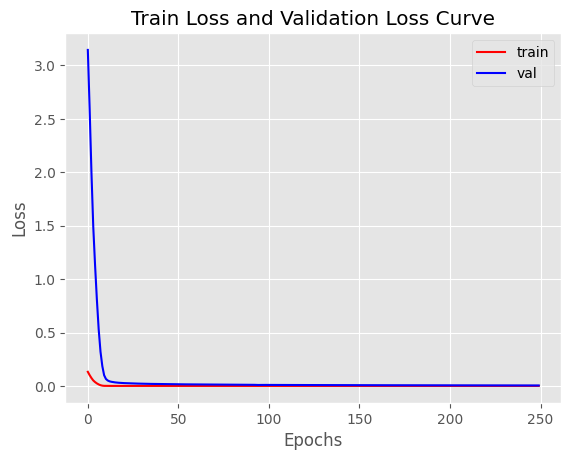

In [37]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [38]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


In [39]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0016055087474759388
RMSE = 0.04006880017514798
MAPE = 0.020421092877024073
R-Squared Score = 0.9795439317712087


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

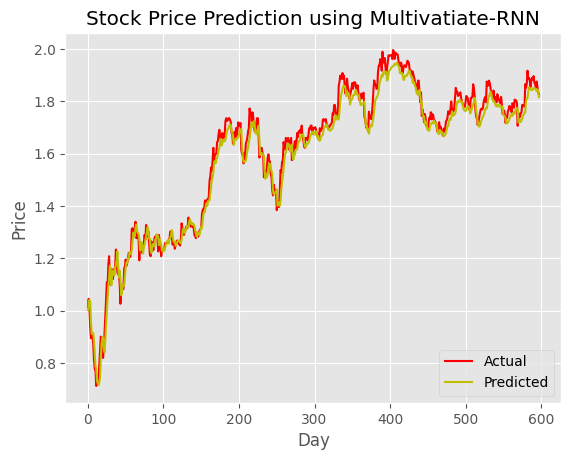

In [40]:
plot_data_2(true, predicted)

In [41]:
# Save a model
model.save('3VAR-VNindex-rnn.keras')

In [42]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [35]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [36]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [39]:
plt.style.use('ggplot')

### Hàm callback

In [40]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var_hpg_gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [42]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-16,2.29,2.29,2.29,2.29,248510
2007-11-19,2.17,2.17,2.17,2.17,120480
2007-11-20,2.08,2.08,2.08,2.08,58710
2007-11-21,1.99,2.16,1.99,2.16,728080
2007-11-22,2.16,2.16,2.08,2.16,266040


In [43]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [45]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [46]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

In [47]:
print(df.describe().volume) 

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

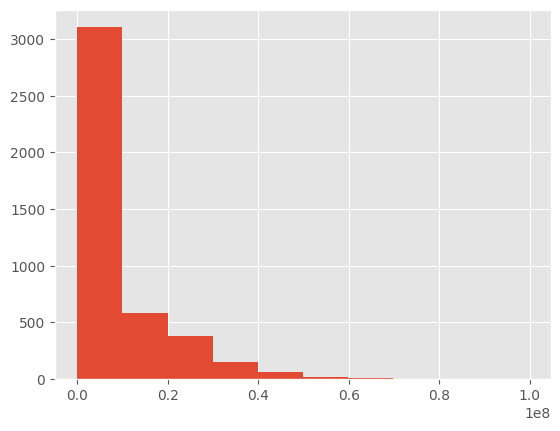

In [49]:
df['volume'].hist(bins= 10)

## Train model / Hàm **fit_model_3()**

In [50]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [51]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [52]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [53]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [54]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [55]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [56]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(4320, 3)


,close,high,low
time,,,
2007-11-16,2.29,2.29,2.29
2007-11-19,2.17,2.17,2.17
2007-11-20,2.08,2.08,2.08
2007-11-21,2.16,2.16,1.99
2007-11-22,2.16,2.16,2.08
...,...,...,...
2025-03-14,27.55,27.85,27.55
2025-03-17,27.85,28.15,27.75
2025-03-18,27.60,28.05,27.60


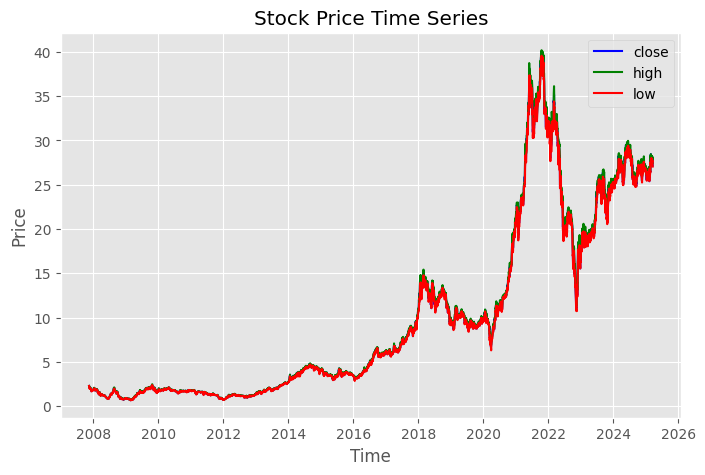

In [57]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [58]:
series.shape

(4320, 3)

In [59]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(3024, 3) (648, 3) (648, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [60]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(3024, 3) (648, 3) (648, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [61]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 2.77487, saving model to 3Var_hpg_gru.h5



Epoch 2: val_loss improved from 2.77487 to 2.27770, saving model to 3Var_hpg_gru.h5



Epoch 3: val_loss improved from 2.27770 to 1.78049, saving model to 3Var_hpg_gru.h5



Epoch 4: val_loss improved from 1.78049 to 1.28512, saving model to 3Var_hpg_gru.h5



Epoch 5: val_loss improved from 1.28512 to 0.81297, saving model to 3Var_hpg_gru.h5



Epoch 6: val_loss improved from 0.81297 to 0.43097, saving model to 3Var_hpg_gru.h5



Epoch 7: val_loss improved from 0.43097 to 0.19826, saving model to 3Var_hpg_gru.h5



Epoch 8: val_loss improved from 0.19826 to 0.09570, saving model to 3Var_hpg_gru.h5



Epoch 9: val_loss improved from 0.09570 to 0.06088, saving model to 3Var_hpg_gru.h5



Epoch 10: val_loss improved from 0.06088 to 0.04691, saving model to 3Var_hpg_gru.h5



Epoch 11: val_loss improved from 0.04691 to 0.03999, saving model to 3Var_hpg_gru.h5



Epoch 12: val_loss improved from 0.03999 to 0.03577, saving model to 3Var_hpg_gru.h5



Epoch 13: val_loss improved from 0.03577 to 0.03265, saving model to 3Var_hpg_gru.h5



Epoch 14: val_loss improved from 0.03265 to 0.03003, saving model to 3Var_hpg_gru.h5



Epoch 15: val_loss improved from 0.03003 to 0.02797, saving model to 3Var_hpg_gru.h5



Epoch 16: val_loss improved from 0.02797 to 0.02613, saving model to 3Var_hpg_gru.h5



Epoch 17: val_loss improved from 0.02613 to 0.02465, saving model to 3Var_hpg_gru.h5



Epoch 18: val_loss improved from 0.02465 to 0.02354, saving model to 3Var_hpg_gru.h5



Epoch 19: val_loss improved from 0.02354 to 0.02254, saving model to 3Var_hpg_gru.h5



Epoch 20: val_loss improved from 0.02254 to 0.02163, saving model to 3Var_hpg_gru.h5



Epoch 21: val_loss improved from 0.02163 to 0.02074, saving model to 3Var_hpg_gru.h5



Epoch 22: val_loss improved from 0.02074 to 0.02006, saving model to 3Var_hpg_gru.h5



Epoch 23: val_loss improved from 0.02006 to 0.01952, saving model to 3Var_hpg_gru.h5



Epoch 24: val_loss improved from 0.01952 to 0.01906, saving model to 3Var_hpg_gru.h5



Epoch 25: val_loss improved from 0.01906 to 0.01869, saving model to 3Var_hpg_gru.h5



Epoch 26: val_loss improved from 0.01869 to 0.01844, saving model to 3Var_hpg_gru.h5



Epoch 27: val_loss improved from 0.01844 to 0.01832, saving model to 3Var_hpg_gru.h5



Epoch 28: val_loss did not improve from 0.01832

Epoch 29: val_loss did not improve from 0.01832

Epoch 30: val_loss did not improve from 0.01832

Epoch 31: val_loss did not improve from 0.01832

Epoch 32: val_loss did not improve from 0.01832

Epoch 33: val_loss did not improve from 0.01832

Epoch 34: val_loss did not improve from 0.01832

Epoch 35: val_loss did not improve from 0.01832

Epoch 36: val_loss did not improve from 0.01832

Epoch 37: val_loss did not improve from 0.01832

Epoch 38: val_loss did not improve from 0.01832

Epoch 39: val_loss did not improve from 0.01832

Epoch 40: val_loss did not improve from 0.01832

Epoch 41: val_loss did not improve from 0.01832

Epoch 42: val_loss did not improve from 0.01832

Epoch 43: val_loss did not improve from 0.01832

Epoch 44: val_loss did not improve from 0.01832

Epoch 45: val_loss did not improve from 0.01832

Epoch 46: val_loss did not improve from 0.01832

Epoch 47: val_loss did not improve from 0.01832

Epoch 48: val_loss 


Epoch 57: val_loss improved from 0.01819 to 0.01797, saving model to 3Var_hpg_gru.h5



Epoch 58: val_loss improved from 0.01797 to 0.01786, saving model to 3Var_hpg_gru.h5



Epoch 59: val_loss improved from 0.01786 to 0.01767, saving model to 3Var_hpg_gru.h5



Epoch 60: val_loss improved from 0.01767 to 0.01711, saving model to 3Var_hpg_gru.h5



Epoch 61: val_loss improved from 0.01711 to 0.01706, saving model to 3Var_hpg_gru.h5



Epoch 62: val_loss improved from 0.01706 to 0.01689, saving model to 3Var_hpg_gru.h5



Epoch 63: val_loss improved from 0.01689 to 0.01665, saving model to 3Var_hpg_gru.h5



Epoch 64: val_loss improved from 0.01665 to 0.01634, saving model to 3Var_hpg_gru.h5



Epoch 65: val_loss improved from 0.01634 to 0.01620, saving model to 3Var_hpg_gru.h5



Epoch 66: val_loss improved from 0.01620 to 0.01591, saving model to 3Var_hpg_gru.h5



Epoch 67: val_loss improved from 0.01591 to 0.01580, saving model to 3Var_hpg_gru.h5



Epoch 68: val_loss improved from 0.01580 to 0.01541, saving model to 3Var_hpg_gru.h5



Epoch 69: val_loss improved from 0.01541 to 0.01534, saving model to 3Var_hpg_gru.h5



Epoch 70: val_loss improved from 0.01534 to 0.01499, saving model to 3Var_hpg_gru.h5



Epoch 71: val_loss improved from 0.01499 to 0.01487, saving model to 3Var_hpg_gru.h5



Epoch 72: val_loss improved from 0.01487 to 0.01451, saving model to 3Var_hpg_gru.h5



Epoch 73: val_loss improved from 0.01451 to 0.01442, saving model to 3Var_hpg_gru.h5



Epoch 74: val_loss improved from 0.01442 to 0.01411, saving model to 3Var_hpg_gru.h5



Epoch 75: val_loss improved from 0.01411 to 0.01401, saving model to 3Var_hpg_gru.h5



Epoch 76: val_loss improved from 0.01401 to 0.01372, saving model to 3Var_hpg_gru.h5



Epoch 77: val_loss improved from 0.01372 to 0.01365, saving model to 3Var_hpg_gru.h5



Epoch 78: val_loss improved from 0.01365 to 0.01322, saving model to 3Var_hpg_gru.h5



Epoch 79: val_loss improved from 0.01322 to 0.01312, saving model to 3Var_hpg_gru.h5



Epoch 80: val_loss improved from 0.01312 to 0.01278, saving model to 3Var_hpg_gru.h5



Epoch 81: val_loss improved from 0.01278 to 0.01264, saving model to 3Var_hpg_gru.h5



Epoch 82: val_loss improved from 0.01264 to 0.01238, saving model to 3Var_hpg_gru.h5



Epoch 83: val_loss improved from 0.01238 to 0.01232, saving model to 3Var_hpg_gru.h5



Epoch 84: val_loss improved from 0.01232 to 0.01186, saving model to 3Var_hpg_gru.h5



Epoch 85: val_loss improved from 0.01186 to 0.01179, saving model to 3Var_hpg_gru.h5



Epoch 86: val_loss improved from 0.01179 to 0.01161, saving model to 3Var_hpg_gru.h5



Epoch 87: val_loss improved from 0.01161 to 0.01130, saving model to 3Var_hpg_gru.h5



Epoch 88: val_loss improved from 0.01130 to 0.01117, saving model to 3Var_hpg_gru.h5



Epoch 89: val_loss improved from 0.01117 to 0.01081, saving model to 3Var_hpg_gru.h5



Epoch 90: val_loss improved from 0.01081 to 0.01071, saving model to 3Var_hpg_gru.h5



Epoch 91: val_loss improved from 0.01071 to 0.01045, saving model to 3Var_hpg_gru.h5



Epoch 92: val_loss improved from 0.01045 to 0.01024, saving model to 3Var_hpg_gru.h5



Epoch 93: val_loss improved from 0.01024 to 0.01020, saving model to 3Var_hpg_gru.h5



Epoch 94: val_loss improved from 0.01020 to 0.00980, saving model to 3Var_hpg_gru.h5



Epoch 95: val_loss improved from 0.00980 to 0.00978, saving model to 3Var_hpg_gru.h5



Epoch 96: val_loss improved from 0.00978 to 0.00948, saving model to 3Var_hpg_gru.h5



Epoch 97: val_loss improved from 0.00948 to 0.00933, saving model to 3Var_hpg_gru.h5



Epoch 98: val_loss improved from 0.00933 to 0.00921, saving model to 3Var_hpg_gru.h5



Epoch 99: val_loss improved from 0.00921 to 0.00886, saving model to 3Var_hpg_gru.h5



Epoch 100: val_loss improved from 0.00886 to 0.00879, saving model to 3Var_hpg_gru.h5



Epoch 101: val_loss improved from 0.00879 to 0.00850, saving model to 3Var_hpg_gru.h5



Epoch 102: val_loss improved from 0.00850 to 0.00836, saving model to 3Var_hpg_gru.h5



Epoch 103: val_loss improved from 0.00836 to 0.00820, saving model to 3Var_hpg_gru.h5



Epoch 104: val_loss improved from 0.00820 to 0.00803, saving model to 3Var_hpg_gru.h5



Epoch 105: val_loss improved from 0.00803 to 0.00779, saving model to 3Var_hpg_gru.h5



Epoch 106: val_loss improved from 0.00779 to 0.00773, saving model to 3Var_hpg_gru.h5



Epoch 107: val_loss improved from 0.00773 to 0.00746, saving model to 3Var_hpg_gru.h5



Epoch 108: val_loss improved from 0.00746 to 0.00734, saving model to 3Var_hpg_gru.h5



Epoch 109: val_loss improved from 0.00734 to 0.00714, saving model to 3Var_hpg_gru.h5



Epoch 110: val_loss improved from 0.00714 to 0.00703, saving model to 3Var_hpg_gru.h5



Epoch 111: val_loss improved from 0.00703 to 0.00679, saving model to 3Var_hpg_gru.h5



Epoch 112: val_loss improved from 0.00679 to 0.00673, saving model to 3Var_hpg_gru.h5



Epoch 113: val_loss improved from 0.00673 to 0.00649, saving model to 3Var_hpg_gru.h5



Epoch 114: val_loss improved from 0.00649 to 0.00636, saving model to 3Var_hpg_gru.h5



Epoch 115: val_loss improved from 0.00636 to 0.00618, saving model to 3Var_hpg_gru.h5



Epoch 116: val_loss improved from 0.00618 to 0.00610, saving model to 3Var_hpg_gru.h5



Epoch 117: val_loss improved from 0.00610 to 0.00583, saving model to 3Var_hpg_gru.h5



Epoch 118: val_loss improved from 0.00583 to 0.00575, saving model to 3Var_hpg_gru.h5



Epoch 119: val_loss improved from 0.00575 to 0.00550, saving model to 3Var_hpg_gru.h5



Epoch 120: val_loss improved from 0.00550 to 0.00543, saving model to 3Var_hpg_gru.h5



Epoch 121: val_loss improved from 0.00543 to 0.00519, saving model to 3Var_hpg_gru.h5



Epoch 122: val_loss improved from 0.00519 to 0.00517, saving model to 3Var_hpg_gru.h5



Epoch 123: val_loss improved from 0.00517 to 0.00484, saving model to 3Var_hpg_gru.h5



Epoch 124: val_loss did not improve from 0.00484

Epoch 125: val_loss improved from 0.00484 to 0.00445, saving model to 3Var_hpg_gru.h5



Epoch 126: val_loss did not improve from 0.00445

Epoch 127: val_loss improved from 0.00445 to 0.00426, saving model to 3Var_hpg_gru.h5



Epoch 128: val_loss did not improve from 0.00426

Epoch 129: val_loss improved from 0.00426 to 0.00390, saving model to 3Var_hpg_gru.h5



Epoch 130: val_loss did not improve from 0.00390

Epoch 131: val_loss improved from 0.00390 to 0.00385, saving model to 3Var_hpg_gru.h5



Epoch 132: val_loss improved from 0.00385 to 0.00384, saving model to 3Var_hpg_gru.h5



Epoch 133: val_loss improved from 0.00384 to 0.00351, saving model to 3Var_hpg_gru.h5



Epoch 134: val_loss did not improve from 0.00351

Epoch 135: val_loss improved from 0.00351 to 0.00344, saving model to 3Var_hpg_gru.h5



Epoch 136: val_loss improved from 0.00344 to 0.00341, saving model to 3Var_hpg_gru.h5



Epoch 137: val_loss improved from 0.00341 to 0.00322, saving model to 3Var_hpg_gru.h5



Epoch 138: val_loss did not improve from 0.00322

Epoch 139: val_loss improved from 0.00322 to 0.00305, saving model to 3Var_hpg_gru.h5



Epoch 140: val_loss did not improve from 0.00305

Epoch 141: val_loss improved from 0.00305 to 0.00297, saving model to 3Var_hpg_gru.h5



Epoch 142: val_loss improved from 0.00297 to 0.00291, saving model to 3Var_hpg_gru.h5



Epoch 143: val_loss improved from 0.00291 to 0.00286, saving model to 3Var_hpg_gru.h5



Epoch 144: val_loss improved from 0.00286 to 0.00281, saving model to 3Var_hpg_gru.h5



Epoch 145: val_loss improved from 0.00281 to 0.00276, saving model to 3Var_hpg_gru.h5



Epoch 146: val_loss improved from 0.00276 to 0.00269, saving model to 3Var_hpg_gru.h5



Epoch 147: val_loss improved from 0.00269 to 0.00267, saving model to 3Var_hpg_gru.h5



Epoch 148: val_loss improved from 0.00267 to 0.00264, saving model to 3Var_hpg_gru.h5



Epoch 149: val_loss improved from 0.00264 to 0.00263, saving model to 3Var_hpg_gru.h5



Epoch 150: val_loss improved from 0.00263 to 0.00261, saving model to 3Var_hpg_gru.h5



Epoch 151: val_loss improved from 0.00261 to 0.00259, saving model to 3Var_hpg_gru.h5



Epoch 152: val_loss improved from 0.00259 to 0.00258, saving model to 3Var_hpg_gru.h5



Epoch 153: val_loss improved from 0.00258 to 0.00258, saving model to 3Var_hpg_gru.h5



Epoch 154: val_loss did not improve from 0.00258

Epoch 155: val_loss did not improve from 0.00258

Epoch 156: val_loss did not improve from 0.00258

Epoch 157: val_loss did not improve from 0.00258

Epoch 158: val_loss did not improve from 0.00258

Epoch 159: val_loss did not improve from 0.00258

Epoch 160: val_loss did not improve from 0.00258

Epoch 161: val_loss did not improve from 0.00258

Epoch 162: val_loss did not improve from 0.00258

Epoch 163: val_loss did not improve from 0.00258

Epoch 164: val_loss did not improve from 0.00258

Epoch 165: val_loss did not improve from 0.00258

Epoch 166: val_loss did not improve from 0.00258

Epoch 167: val_loss did not improve from 0.00258

Epoch 168: val_loss did not improve from 0.00258

Epoch 169: val_loss did not improve from 0.00258

Epoch 170: val_loss did not improve from 0.00258

Epoch 171: val_loss did not improve from 0.00258

Epoch 172: val_loss did not improve from 0.00258

Epoch 173: val_loss did not improve from 0.00258


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [62]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00258

Epoch 2: val_loss did not improve from 0.00258

Epoch 3: val_loss did not improve from 0.00258

Epoch 4: val_loss did not improve from 0.00258

Epoch 5: val_loss did not improve from 0.00258

Epoch 6: val_loss did not improve from 0.00258

Epoch 7: val_loss did not improve from 0.00258

Epoch 8: val_loss did not improve from 0.00258

Epoch 9: val_loss did not improve from 0.00258

Epoch 10: val_loss did not improve from 0.00258

Epoch 11: val_loss did not improve from 0.00258

Epoch 12: val_loss did not improve from 0.00258

Epoch 13: val_loss did not improve from 0.00258

Epoch 14: val_loss did not improve from 0.00258

Epoch 15: val_loss did not improve from 0.00258

Epoch 16: val_loss did not improve from 0.00258

Epoch 17: val_loss did not improve from 0.00258

Epoch 18: val_loss did not improve from 0.00258

Epoch 19: val_loss did not improve from 0.00258

Epoch 20: val_loss did not improve from 0.00258

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

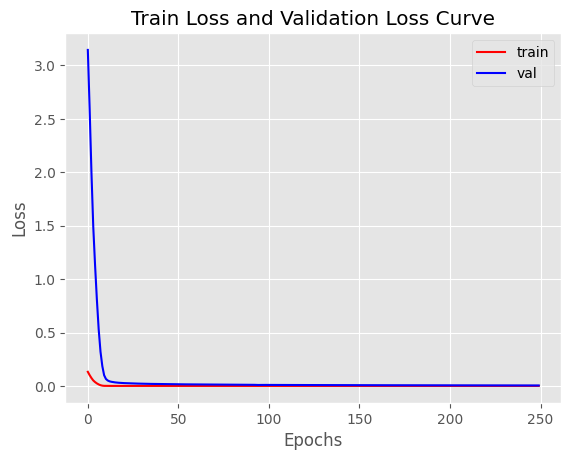

In [63]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [64]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


In [65]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0028305918697195116
RMSE = 0.05320330694345523
MAPE = 0.028555618044915215
R-Squared Score = 0.9659449728468578


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

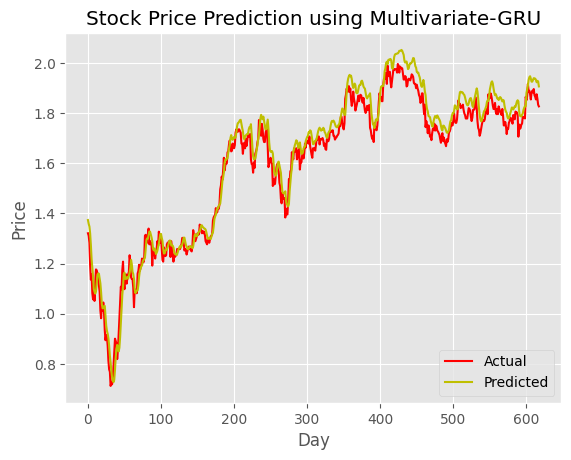

In [66]:
plot_data_3(true, predicted)

In [67]:
# Save a model
model.save('3VAR-hpg-gru.keras')

In [206]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [10]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

2025-06-02 14:24:36.106182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748874276.306124      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748874276.365105      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [14]:
plt.style.use('ggplot')

### Hàm callback

In [15]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var-hpg-lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [17]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-16,2.29,2.29,2.29,2.29,248510
2007-11-19,2.17,2.17,2.17,2.17,120480
2007-11-20,2.08,2.08,2.08,2.08,58710
2007-11-21,1.99,2.16,1.99,2.16,728080
2007-11-22,2.16,2.16,2.08,2.16,266040


In [18]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [19]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [20]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

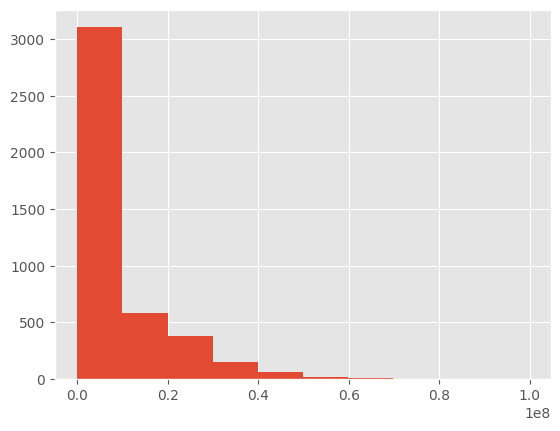

In [21]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

## Train model / Hàm **fit_model_4()**

In [22]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [23]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [24]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [25]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [26]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [27]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [28]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(4320, 3)


,close,high,low
time,,,
2007-11-16,2.29,2.29,2.29
2007-11-19,2.17,2.17,2.17
2007-11-20,2.08,2.08,2.08
2007-11-21,2.16,2.16,1.99
2007-11-22,2.16,2.16,2.08
...,...,...,...
2025-03-14,27.55,27.85,27.55
2025-03-17,27.85,28.15,27.75
2025-03-18,27.60,28.05,27.60


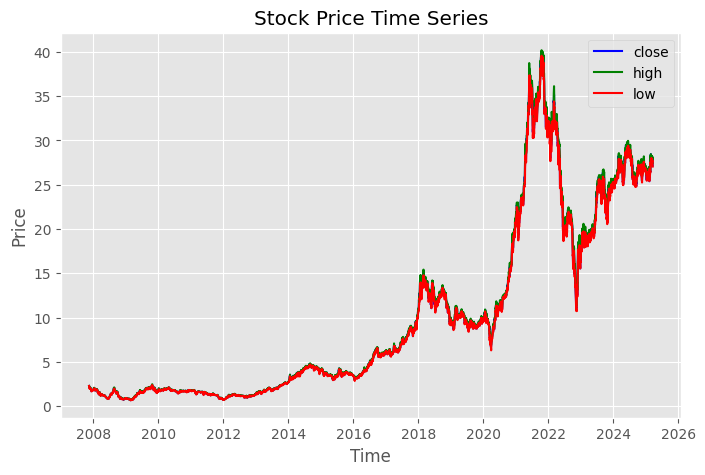

In [29]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [30]:
series.shape

(4320, 3)

In [31]:

n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(3024, 3) (648, 3) (648, 3)


In [ ]:
"""
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 28)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,29 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)
"""

(3785, 3) (1004, 3) (1004, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [32]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(3024, 3) (648, 3) (648, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [26]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


I0000 00:00:1748834330.361279      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748834330.362240      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1748834337.461107     104 service.cc:148] XLA service 0x26d45350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748834337.461633     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capabi


Epoch 1: val_loss improved from inf to 0.46807, saving model to 3Var-hpg-lstm.h5

Epoch 2: val_loss did not improve from 0.46807

Epoch 3: val_loss did not improve from 0.46807

Epoch 4: val_loss did not improve from 0.46807

Epoch 5: val_loss did not improve from 0.46807

Epoch 6: val_loss improved from 0.46807 to 0.23805, saving model to 3Var-hpg-lstm.h5

Epoch 7: val_loss improved from 0.23805 to 0.02224, saving model to 3Var-hpg-lstm.h5

Epoch 8: val_loss did not improve from 0.02224

Epoch 9: val_loss did not improve from 0.02224

Epoch 10: val_loss did not improve from 0.02224

Epoch 11: val_loss did not improve from 0.02224

Epoch 12: val_loss did not improve from 0.02224

Epoch 13: val_loss did not improve from 0.02224

Epoch 14: val_loss did not improve from 0.02224

Epoch 15: val_loss did not improve from 0.02224

Epoch 16: val_loss did not improve from 0.02224

Epoch 17: val_loss did not improve from 0.02224

Epoch 18: val_loss did not improve from 0.02224

Epoch 19: val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00893

Epoch 2: val_loss did not improve from 0.00893

Epoch 3: val_loss did not improve from 0.00893

Epoch 4: val_loss did not improve from 0.00893

Epoch 5: val_loss did not improve from 0.00893

Epoch 6: val_loss did not improve from 0.00893

Epoch 7: val_loss did not improve from 0.00893

Epoch 8: val_loss did not improve from 0.00893

Epoch 9: val_loss did not improve from 0.00893

Epoch 10: val_loss did not improve from 0.00893

Epoch 11: val_loss did not improve from 0.00893

Epoch 12: val_loss did not improve from 0.00893

Epoch 13: val_loss did not improve from 0.00893

Epoch 14: val_loss did not improve from 0.00893

Epoch 15: val_loss did not improve from 0.00893

Epoch 16: val_loss did not improve from 0.00893

Epoch 17: val_loss did not improve from 0.00893

Epoch 18: val_loss did not improve from 0.00893

Epoch 19: val_loss did not improve from 0.00893

Epoch 20: val_loss did not improve from 0.00893

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00408

Epoch 2: val_loss did not improve from 0.00408

Epoch 3: val_loss did not improve from 0.00408

Epoch 4: val_loss did not improve from 0.00408

Epoch 5: val_loss did not improve from 0.00408

Epoch 6: val_loss did not improve from 0.00408

Epoch 7: val_loss did not improve from 0.00408

Epoch 8: val_loss did not improve from 0.00408

Epoch 9: val_loss did not improve from 0.00408

Epoch 10: val_loss did not improve from 0.00408

Epoch 11: val_loss did not improve from 0.00408

Epoch 12: val_loss did not improve from 0.00408

Epoch 13: val_loss did not improve from 0.00408

Epoch 14: val_loss did not improve from 0.00408

Epoch 15: val_loss did not improve from 0.00408

Epoch 16: val_loss did not improve from 0.00408

Epoch 17: val_loss did not improve from 0.00408

Epoch 18: val_loss did not improve from 0.00408

Epoch 19: val_loss did not improve from 0.00408

Epoch 20: val_loss did not improve from 0.00408

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [38]:
timesteps = 30
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 200

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00381

Epoch 2: val_loss did not improve from 0.00381

Epoch 3: val_loss did not improve from 0.00381

Epoch 4: val_loss did not improve from 0.00381

Epoch 5: val_loss did not improve from 0.00381

Epoch 6: val_loss did not improve from 0.00381

Epoch 7: val_loss did not improve from 0.00381

Epoch 8: val_loss did not improve from 0.00381

Epoch 9: val_loss did not improve from 0.00381

Epoch 10: val_loss did not improve from 0.00381

Epoch 11: val_loss did not improve from 0.00381

Epoch 12: val_loss did not improve from 0.00381

Epoch 13: val_loss did not improve from 0.00381

Epoch 14: val_loss did not improve from 0.00381

Epoch 15: val_loss did not improve from 0.00381

Epoch 16: val_loss did not improve from 0.00381

Epoch 17: val_loss did not improve from 0.00381

Epoch 18: val_loss did not improve from 0.00381

Epoch 19: val_loss did not improve from 0.00381

Epoch 20: val_loss did not improve from 0.00381

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

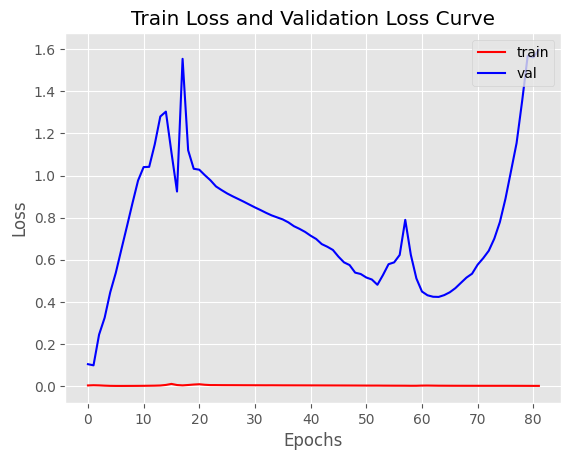

In [39]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [40]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [41]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.018757323584869878
RMSE = 0.13695737871640898
MAPE = 0.073462025116832
R-Squared Score = 0.7743294712189233


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

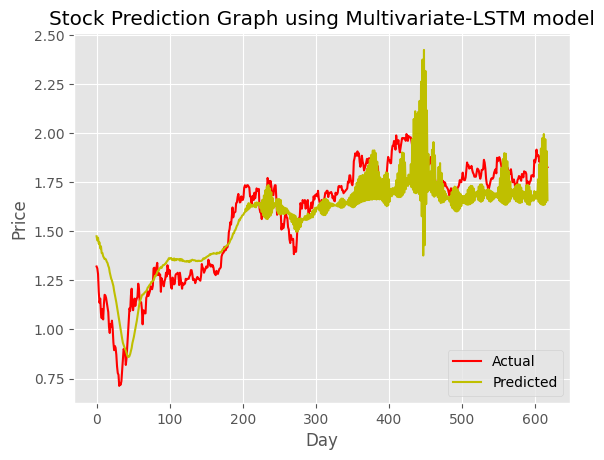

In [42]:
plot_data_4(true, predicted)

In [99]:
# Save a model
model.save('3VAR-hpg-lstm.keras')

In [ ]:
del model